# Gas Plume Detection - Main Pipeline
Streamlined pipeline with configurable processing steps

## Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from scipy import ndimage
from skimage import feature, measure, morphology
import cv2

## Functions

In [2]:
def run_pipeline(image_num, processing_steps, cloud_params, cutoff_ratio, malt, param_sets, detection_color, sanity_check_color, mode_final=0):
    """
    Main pipeline: process image through cloud removal, frequency filtering, and blob detection.
    
    Parameters:
    - image_num: Image number (1-7)
    - processing_steps: [cloud_removal, frequency_filtering] (1=enable, 0=disable)
    - cloud_params: Cloud detection parameters
    - cutoff_ratio: Frequency filtering cutoff ratio
    - malt: High-pass multiplier
    - param_sets: Blob detection parameter sets
    - detection_color: RGB color for blob highlighting
    - sanity_check_color: RGB color for sanity check blending
    - mode_final: 0=normal mode, 1=overview mode
    """
    
    rgb, ace, ground_truth = load_image_set(image_num)
    
    if mode_final == 0:
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        axes[0].imshow(rgb)
        axes[0].set_title(f'RGB Image (Image {image_num})', fontsize=14)
        axes[0].axis('off')
        axes[1].imshow(ace, cmap='gray')
        axes[1].set_title(f'ACE Detection (Image {image_num})', fontsize=14)
        axes[1].axis('off')
        axes[2].imshow(ground_truth)
        axes[2].set_title(f'Ground Truth Location (Image {image_num})', fontsize=14)
        axes[2].axis('off')
        plt.tight_layout()
        plt.show()
    
    ace_current = ace.copy()
    ace_no_clouds = None
    filtered_ace = None
    
    if processing_steps[0] == 1:
        ace_no_clouds, cloud_mask = apply_cloud_removal(ace_current, rgb, cloud_params)
        ace_current = ace_no_clouds
    
    if processing_steps[1] == 1:
        filtered_ace = apply_lowpass_highpass_filter(ace_current, cutoff_ratio=cutoff_ratio, malt=malt)
        ace_current = filtered_ace
    
    final_ace = ace_current
    detection_results, final_ace_uint8 = detect_blobs(final_ace, param_sets)
    
    if mode_final == 0:
        # Sanity check plots
        plots_to_show = [('Original RGB', rgb, None)]
        plots_to_show.append(('Original ACE', rgb, ace))
        if ace_no_clouds is not None:
            plots_to_show.append(('Cloud-Removed ACE', rgb, ace_no_clouds))
        if filtered_ace is not None:
            plots_to_show.append(('Filtered ACE', rgb, filtered_ace))
        
        num_plots = len(plots_to_show)
        fig, axes = plt.subplots(1, num_plots, figsize=(6 * num_plots, 6))
        if num_plots == 1:
            axes = [axes]
        
        for idx, (title, rgb_img, ace_img) in enumerate(plots_to_show):
            if ace_img is None:
                axes[idx].imshow(rgb_img)
            else:
                ace_norm = (ace_img - ace_img.min()) / (ace_img.max() - ace_img.min()) if ace_img.max() > ace_img.min() else np.zeros_like(ace_img)
                blended = blend_with_ace(rgb_img, ace_norm, sanity_check_color)
                axes[idx].imshow(blended)
            axes[idx].set_title(title, fontsize=12, fontweight='bold')
            axes[idx].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Blob detection plots
        num_presets = len(param_sets)
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.flatten()
        
        axes[0].imshow(final_ace, cmap='gray')
        axes[0].set_title('Final Processed ACE\n(No Detections)', fontsize=12, fontweight='bold')
        axes[0].axis('off')
        
        for idx, (name, keypoints) in enumerate(detection_results.items(), start=1):
            visualization = create_blob_visualization(final_ace_uint8, keypoints, detection_color)
            axes[idx].imshow(visualization)
            axes[idx].set_title(f'{name}\n({len(keypoints)} blobs)', fontsize=12, fontweight='bold')
            axes[idx].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    else:
        # Final overview mode: 2x3 grid
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        axes[0, 0].imshow(rgb)
        axes[0, 0].set_title('RGB Image', fontsize=12, fontweight='bold')
        axes[0, 0].axis('off')
        
        filtered_ace_norm = (final_ace - final_ace.min()) / (final_ace.max() - final_ace.min()) if final_ace.max() > final_ace.min() else np.zeros_like(final_ace)
        blended_filtered = blend_with_ace(rgb, filtered_ace_norm, sanity_check_color)
        axes[0, 1].imshow(blended_filtered)
        axes[0, 1].set_title('Filtered ACE (Overlay)', fontsize=12, fontweight='bold')
        axes[0, 1].axis('off')
        
        axes[0, 2].imshow(ground_truth)
        axes[0, 2].set_title('Ground Truth', fontsize=12, fontweight='bold')
        axes[0, 2].axis('off')
        
        axes[1, 0].imshow(ace, cmap='gray')
        axes[1, 0].set_title('ACE Detection', fontsize=12, fontweight='bold')
        axes[1, 0].axis('off')
        
        axes[1, 1].imshow(final_ace, cmap='gray')
        axes[1, 1].set_title('Final Processed ACE', fontsize=12, fontweight='bold')
        axes[1, 1].axis('off')
        
        ace_with_blobs = create_overlay_blob_visualization(final_ace_uint8, 
                                                            detection_results['Small Blobs'], 
                                                            detection_results['Loose'],
                                                            small_color=np.array([255, 0, 0]),
                                                            loose_color=np.array([255, 165, 0]))
        axes[1, 2].imshow(ace_with_blobs)
        small_count = len(detection_results['Small Blobs'])
        loose_count = len(detection_results['Loose'])
        axes[1, 2].set_title(f'Blob Detection\nSmall: {small_count} | Loose: {loose_count}', fontsize=12, fontweight='bold')
        axes[1, 2].axis('off')
        
        plt.tight_layout()
        plt.show()


# ==================== HELPER FUNCTIONS ====================

def load_image_set(image_num, data_path='CleanImages'):
    """Load RGB, ACE, and ground truth images."""
    base_path = Path(r'C:\Users\arrow\OneDrive\Documents\GitHub\EMIT-GTA-Processing\Abby\CleanImages')
    
    rgb_img = Image.open(base_path / f'{image_num}_FalseRGB.png')
    rgb_array = np.array(rgb_img)
    
    ace_img = Image.open(base_path / f'{image_num}_ACE.png')
    if ace_img.mode != 'L':
        ace_img = ace_img.convert('L')
    ace_array = np.array(ace_img)
    
    gt_img = Image.open(base_path / f'{image_num}_Real.png')
    gt_array = np.array(gt_img)
    
    return rgb_array, ace_array, gt_array


def apply_lowpass_highpass_filter(img_array, cutoff_ratio=0.1, malt=1):
    """Apply frequency domain filtering."""
    fft = np.fft.fft2(img_array)
    fft_shifted = np.fft.fftshift(fft)
    
    rows, cols = img_array.shape
    center_row, center_col = rows // 2, cols // 2
    y, x = np.ogrid[:rows, :cols]
    distance = np.sqrt((x - center_col)**2 + (y - center_row)**2)
    cutoff = cutoff_ratio * min(rows, cols)
    
    low_pass_mask = distance <= cutoff
    fft_low_pass = fft_shifted * low_pass_mask
    
    high_pass_mask = distance > cutoff
    fft_high_pass = fft_shifted * high_pass_mask
    
    img_low_pass = np.abs(np.fft.ifft2(np.fft.ifftshift(fft_low_pass)))
    img_high_pass = np.abs(np.fft.ifft2(np.fft.ifftshift(fft_high_pass)))
    img_difference = np.maximum(img_low_pass - img_high_pass * malt, 0)
    
    return img_difference


def apply_cloud_removal(ace, rgb, cloud_params):
    """Detect and remove clouds from ACE using RGB guidance."""
    white_threshold = cloud_params['white_threshold']
    canny_sigma = cloud_params['canny_sigma']
    canny_low = cloud_params['canny_low']
    canny_high = cloud_params['canny_high']
    min_blob_size = cloud_params['min_blob_size']
    edge_threshold_percent = cloud_params['edge_threshold_percent']
    edge_distance = cloud_params['edge_distance']
    ace_intensity_threshold = cloud_params['ace_intensity_threshold']
    cloud_growth_factor = cloud_params['cloud_growth_factor']
    min_cloud_size = cloud_params['min_cloud_size']
    
    has_alpha = rgb.shape[2] == 4
    rgb_no_alpha = rgb[:, :, :3] if has_alpha else rgb
    white_mask = np.all(rgb_no_alpha >= white_threshold, axis=2)
    
    rgb_gray = np.mean(rgb_no_alpha, axis=2)
    edges = feature.canny(rgb_gray, sigma=canny_sigma, low_threshold=canny_low, high_threshold=canny_high)
    
    labeled_blobs = measure.label(white_mask, connectivity=2)
    blob_properties = measure.regionprops(labeled_blobs)
    large_blobs = [prop for prop in blob_properties if prop.area >= min_blob_size]
    
    cloud_mask = np.zeros_like(white_mask, dtype=bool)
    for prop in large_blobs:
        blob = (labeled_blobs == prop.label)
        eroded = morphology.binary_erosion(blob)
        perimeter = blob & ~eroded
        perimeter_pixels = np.sum(perimeter)
        
        if perimeter_pixels == 0:
            continue
        
        dilated_perimeter = morphology.binary_dilation(perimeter, morphology.disk(edge_distance))
        perimeter_with_edges = dilated_perimeter & edges
        edge_pixels = np.sum(perimeter_with_edges)
        edge_percentage = (edge_pixels / perimeter_pixels) * 100
        
        if edge_percentage >= edge_threshold_percent:
            cloud_mask |= blob
    
    ace_no_clouds = ace.copy()
    expanded_cloud_mask = np.zeros_like(cloud_mask, dtype=bool)
    
    labeled_clouds = measure.label(cloud_mask, connectivity=2)
    cloud_regions = measure.regionprops(labeled_clouds)
    
    for region in cloud_regions:
        original_size = region.area
        max_size = int(original_size * cloud_growth_factor)
        grown_region = (labeled_clouds == region.label).copy()
        current_size = original_size
        
        edge_pixels = []
        cloud_coords = np.argwhere(grown_region)
        
        for coord in cloud_coords:
            y, x = coord
            for dy in [-1, 0, 1]:
                for dx in [-1, 0, 1]:
                    if dy == 0 and dx == 0:
                        continue
                    ny, nx = y + dy, x + dx
                    if 0 <= ny < ace.shape[0] and 0 <= nx < ace.shape[1]:
                        if not grown_region[ny, nx]:
                            edge_pixels.append((y, x))
                            break
                if (y, x) in edge_pixels:
                    break
        
        edge_pixels = list(set(edge_pixels))
        visited = set(edge_pixels)
        
        while edge_pixels and current_size < max_size:
            y, x = edge_pixels.pop(0)
            
            for dy in [-1, 0, 1]:
                for dx in [-1, 0, 1]:
                    if dy == 0 and dx == 0:
                        continue
                    
                    ny, nx = y + dy, x + dx
                    
                    if not (0 <= ny < ace.shape[0] and 0 <= nx < ace.shape[1]):
                        continue
                    
                    if grown_region[ny, nx] or (ny, nx) in visited:
                        continue
                    
                    if ace[ny, nx] >= ace_intensity_threshold:
                        grown_region[ny, nx] = True
                        current_size += 1
                        edge_pixels.append((ny, nx))
                        visited.add((ny, nx))
                        
                        if current_size >= max_size:
                            break
                
                if current_size >= max_size:
                    break
        
        expanded_cloud_mask |= grown_region
    
    labeled_grown_clouds = measure.label(expanded_cloud_mask, connectivity=2)
    grown_cloud_properties = measure.regionprops(labeled_grown_clouds)
    
    final_cloud_mask = np.zeros_like(expanded_cloud_mask, dtype=bool)
    for prop in grown_cloud_properties:
        if prop.area >= min_cloud_size:
            final_cloud_mask |= (labeled_grown_clouds == prop.label)
    
    ace_no_clouds[final_cloud_mask] = 0
    
    return ace_no_clouds, final_cloud_mask


def detect_blobs(filtered_ace, param_sets):
    """Detect blobs using multiple parameter presets."""
    filtered_ace_uint8 = ((filtered_ace - filtered_ace.min()) / 
                          (filtered_ace.max() - filtered_ace.min()) * 255).astype(np.uint8)
    
    detection_results = {}
    for name, params in param_sets.items():
        detector = cv2.SimpleBlobDetector_create(params)
        keypoints = detector.detect(filtered_ace_uint8)
        detection_results[name] = keypoints
    
    return detection_results, filtered_ace_uint8


def blend_with_ace(rgb_img, ace_weight, target_color):
    """Blend RGB with target color using ACE intensity as weight."""
    rgb_display = rgb_img[:, :, :3] if rgb_img.shape[2] == 4 else rgb_img
    rgb_display = rgb_display.astype(float)
    weight_3d = np.stack([ace_weight, ace_weight, ace_weight], axis=2)
    blended = (1 - weight_3d) * rgb_display + weight_3d * target_color
    return np.clip(blended, 0, 255).astype(np.uint8)


def create_blob_visualization(ace_img, keypoints, color):
    """Create visualization with detected blobs highlighted."""
    ace_rgb = np.stack([ace_img, ace_img, ace_img], axis=2)
    blob_mask = np.zeros(ace_img.shape, dtype=bool)
    
    for kp in keypoints:
        x, y = int(kp.pt[0]), int(kp.pt[1])
        radius = int(kp.size / 2)
        y_coords, x_coords = np.ogrid[:ace_img.shape[0], :ace_img.shape[1]]
        circle_mask = (x_coords - x)**2 + (y_coords - y)**2 <= radius**2
        blob_mask |= circle_mask
    
    ace_rgb[blob_mask] = color
    return ace_rgb.astype(np.uint8)


def create_overlay_blob_visualization(ace_img, small_keypoints, loose_keypoints, small_color, loose_color, alpha=0.8):
    """Create visualization with two sets of blobs overlayed with transparency."""
    ace_rgb = np.stack([ace_img, ace_img, ace_img], axis=2).astype(float)
    overlay = np.zeros_like(ace_rgb)
    
    # Draw loose blobs first (appear underneath when overlapping)
    for kp in loose_keypoints:
        x, y = int(kp.pt[0]), int(kp.pt[1])
        radius = int(kp.size / 2)
        y_coords, x_coords = np.ogrid[:ace_img.shape[0], :ace_img.shape[1]]
        circle_mask = (x_coords - x)**2 + (y_coords - y)**2 <= radius**2
        overlay[circle_mask] = loose_color
    
    # Draw small blobs on top
    for kp in small_keypoints:
        x, y = int(kp.pt[0]), int(kp.pt[1])
        radius = int(kp.size / 2)
        y_coords, x_coords = np.ogrid[:ace_img.shape[0], :ace_img.shape[1]]
        circle_mask = (x_coords - x)**2 + (y_coords - y)**2 <= radius**2
        overlay[circle_mask] = small_color
    
    blob_mask = np.any(overlay > 0, axis=2)
    result = ace_rgb.copy()
    result[blob_mask] = (1 - alpha) * ace_rgb[blob_mask] + alpha * overlay[blob_mask]
    
    return np.clip(result, 0, 255).astype(np.uint8)

## Parameters

In [3]:
# ============================================
# CLOUD DETECTION PARAMETERS
# ============================================
cloud_params = {
    'white_threshold': 225,        # Minimum RGB value for white detection
    'canny_sigma': 2.0,            # Gaussian sigma for edge detection
    'canny_low': 0.1,              # Canny low threshold
    'canny_high': 0.2,             # Canny high threshold
    'min_blob_size': 50,           # Minimum blob size (filters RGB noise)
    'edge_threshold_percent': 60,  # Minimum % of perimeter with edges
    'edge_distance': 2,            # Border thickness for edge detection
    'ace_intensity_threshold': 150, # Minimum ACE intensity for cloud region
    'cloud_growth_factor': 3,      # Maximum growth factor from RGB detection
    'min_cloud_size': 150          # Minimum cloud size after region growing
}

# ============================================
# FREQUENCY FILTERING PARAMETERS
# ============================================
cutoff_ratio = 0.15  # Cutoff ratio for frequency filtering
malt = 1.5           # High-pass multiplier

# ============================================
# BLOB DETECTION PARAMETERS
# ============================================
detection_color = np.array([255, 0, 0])  # Red

# Preset 1: LOOSE
params_loose = cv2.SimpleBlobDetector_Params()
params_loose.minThreshold = 10
params_loose.maxThreshold = 255
params_loose.filterByArea = True
params_loose.minArea = 50
params_loose.maxArea = 50000
params_loose.filterByCircularity = False
params_loose.filterByConvexity = False
params_loose.filterByInertia = False

# Preset 2: TIGHT
params_tight = cv2.SimpleBlobDetector_Params()
params_tight.minThreshold = 50
params_tight.maxThreshold = 255
params_tight.filterByArea = True
params_tight.minArea = 200
params_tight.maxArea = 10000
params_tight.filterByCircularity = True
params_tight.minCircularity = 0.3
params_tight.filterByConvexity = True
params_tight.minConvexity = 0.5
params_tight.filterByInertia = False

# Preset 3: LARGE BLOBS
params_large = cv2.SimpleBlobDetector_Params()
params_large.minThreshold = 10
params_large.maxThreshold = 255
params_large.filterByArea = True
params_large.minArea = 1000
params_large.maxArea = 100000
params_large.filterByCircularity = False
params_large.filterByConvexity = False
params_large.filterByInertia = False

# Preset 4: SMALL BLOBS
params_small = cv2.SimpleBlobDetector_Params()
params_small.minThreshold = 10
params_small.maxThreshold = 255
params_small.filterByArea = True
params_small.minArea = 20
params_small.maxArea = 500
params_small.filterByCircularity = False
params_small.filterByConvexity = False
params_small.filterByInertia = False

# Preset 5: ELONGATED
params_elongated = cv2.SimpleBlobDetector_Params()
params_elongated.minThreshold = 10
params_elongated.maxThreshold = 255
params_elongated.filterByArea = True
params_elongated.minArea = 100
params_elongated.maxArea = 50000
params_elongated.filterByCircularity = True
params_elongated.minCircularity = 0.01
params_elongated.maxCircularity = 0.5
params_elongated.filterByConvexity = False
params_elongated.filterByInertia = True
params_elongated.minInertiaRatio = 0.01
params_elongated.maxInertiaRatio = 0.5

param_sets = {
    'Loose': params_loose,
    'Tight': params_tight,
    'Large Blobs': params_large,
    'Small Blobs': params_small,
    'Elongated': params_elongated
}

# ============================================
# VISUALIZATION PARAMETERS
# ============================================
sanity_check_color = np.array([0, 255, 0])  # Green

## Run Pipeline

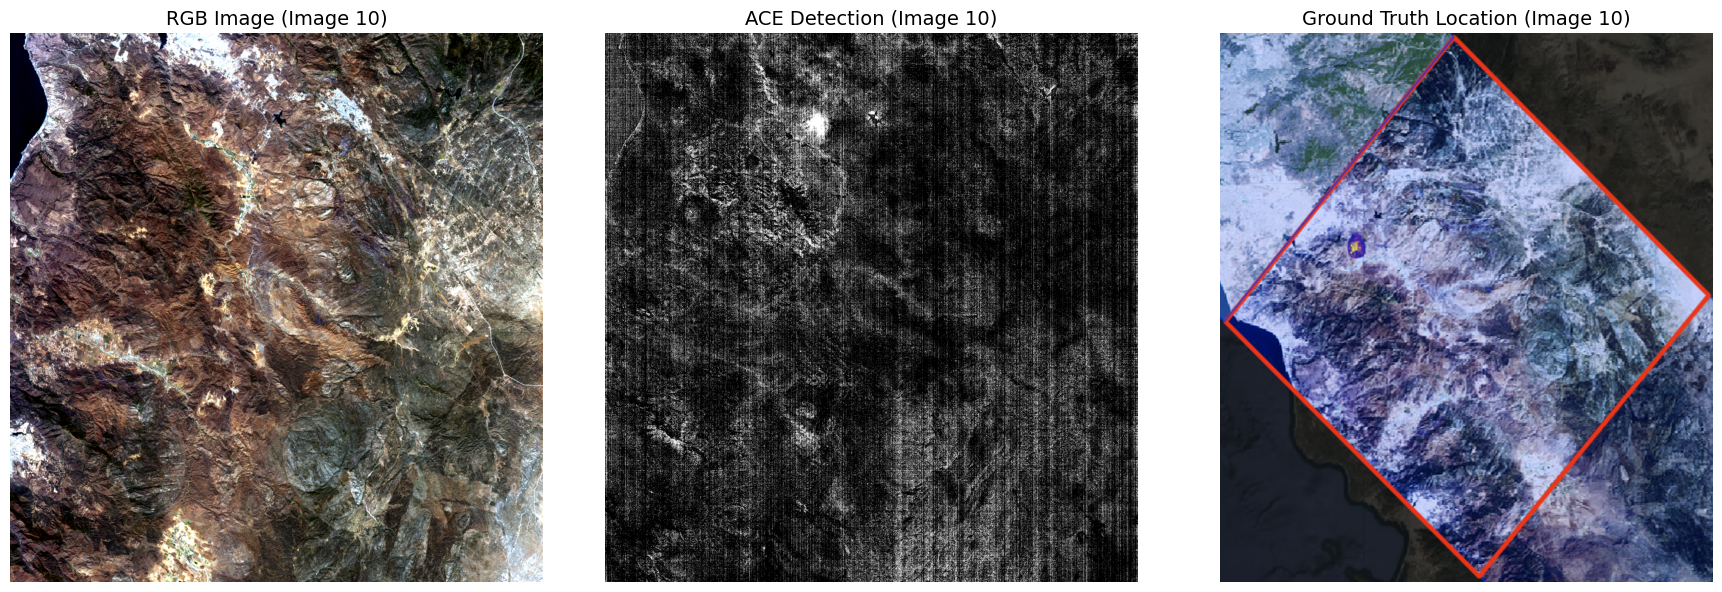

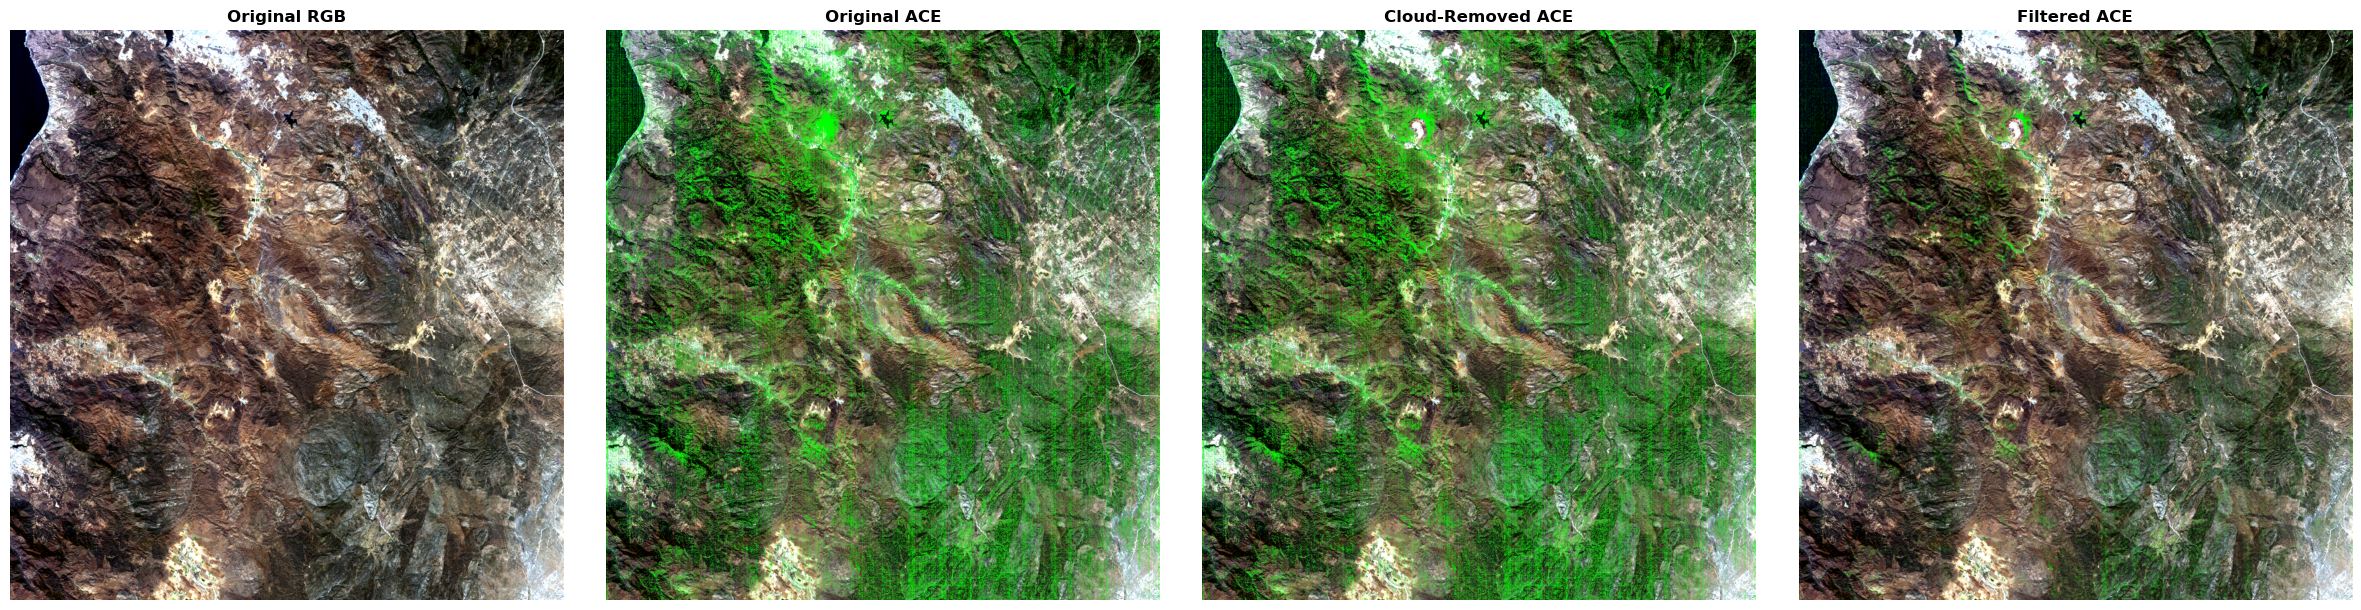

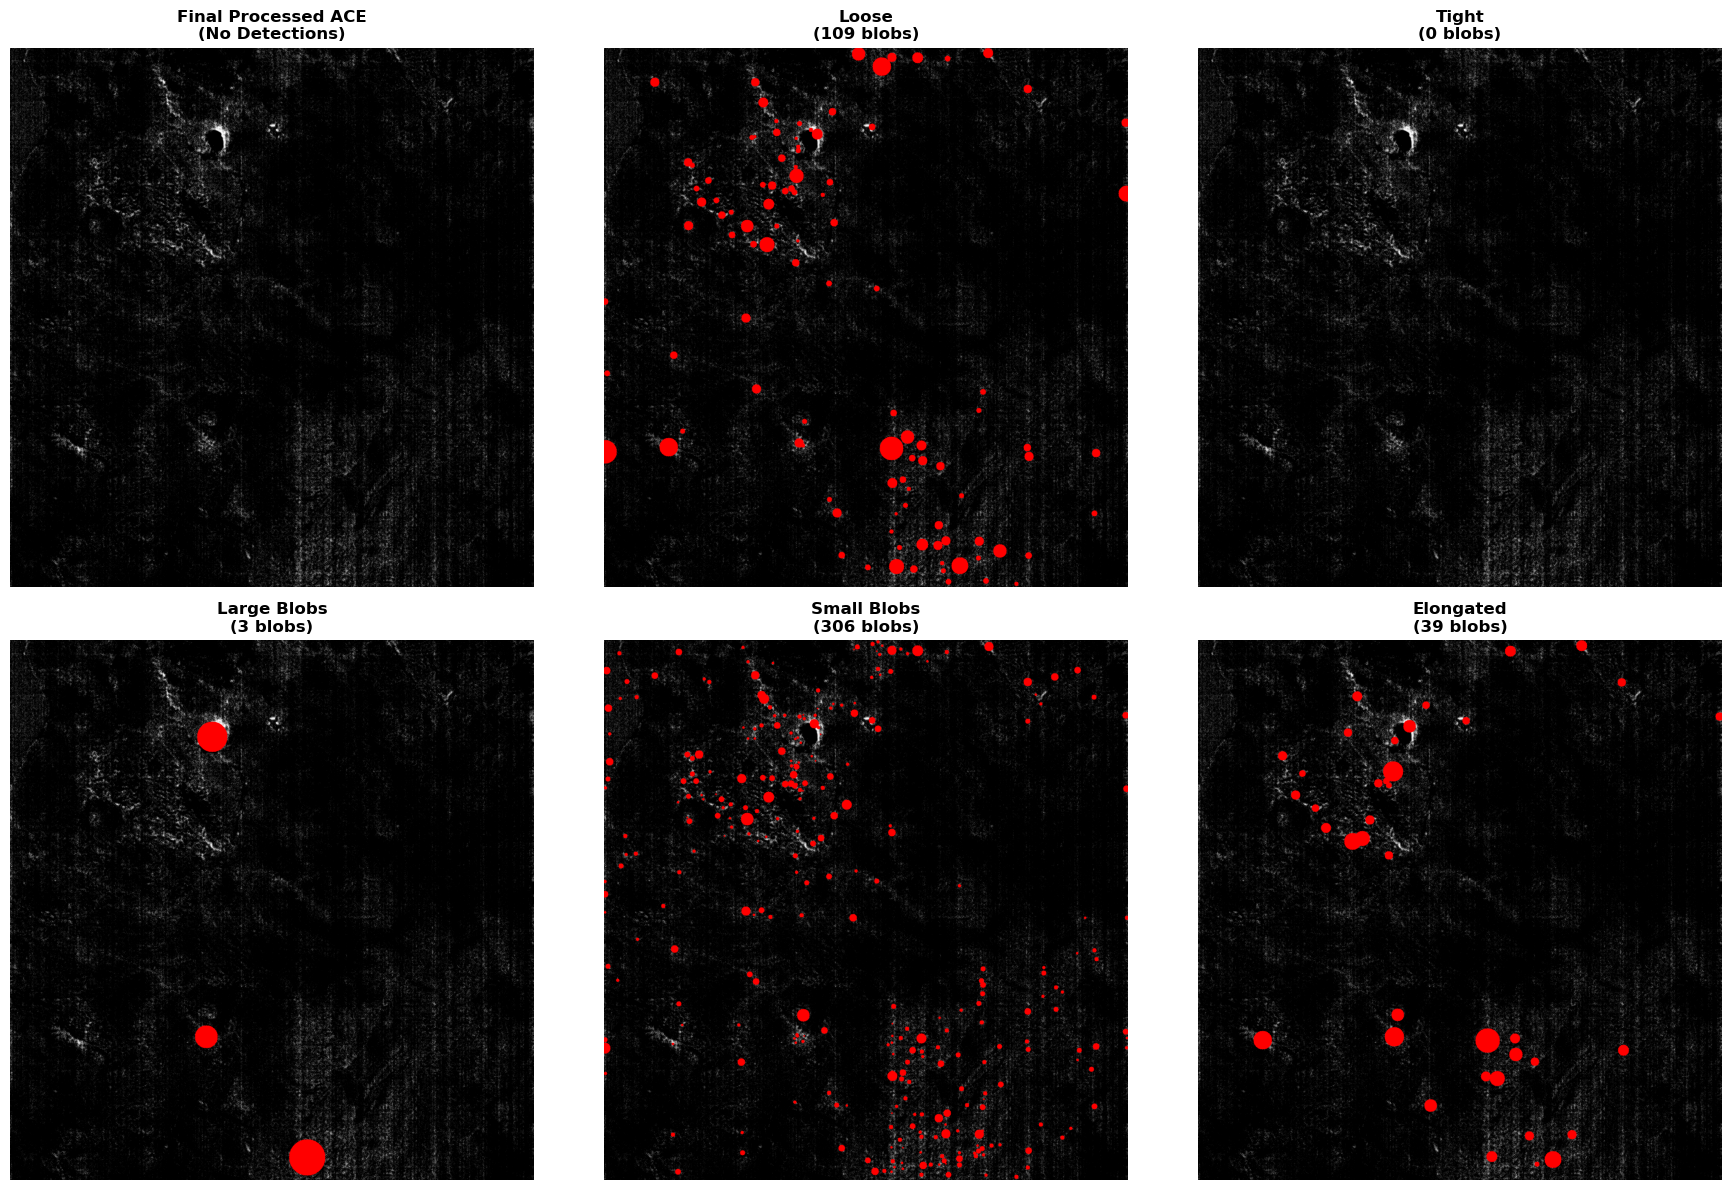

In [5]:
# ============================================
# IMAGE SELECTION
# ============================================
image_num = 10
processing_steps = [1, 1]  # [cloud_removal, frequency_filtering] (1=enable, 0=disable)
Mode_Final = 0             # 0=normal mode, 1=overview mode

run_pipeline(image_num, processing_steps, cloud_params, cutoff_ratio, malt, param_sets, detection_color, sanity_check_color, Mode_Final)

In [ ]:
# ============================================
# BATCH PROCESSING
# ============================================
for img_num in range(1, 10):
    run_pipeline(img_num, processing_steps, cloud_params, cutoff_ratio, malt, param_sets, detection_color, sanity_check_color, Mode_Final)